# Imbalanced bainary classification

## Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel('data/Training.xlsb', index_col='ID', engine='pyxlsb')
pd.set_option('display.max_columns', 30)
df.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,MARKER
ID,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.198778,0.099389,0.00,799.90,1.777556,0.888778,13,3.49,Woman,33.750000,Mogilev region,132,NE employee,Secondary education (plus special education),Married,2 Two,property,No,Works,Yes,Yes,No,Yes,No,0
2,0.043000,0.021264,49.97,173.03,0.384511,0.190143,13,3.49,Woman,33.250000,Minsk region,6,NE employee,Secondary education (plus special education),Married,2 Two,otherwise,No,Works,Yes,Yes,Yes,Yes,No,0
3,0.067073,0.067073,0.00,329.90,0.599818,0.599818,13,3.49,Woman,38.583333,Vitebsk region,71,NE employee,Secondary education (plus special education),Divorced/widow,1 One,property,No,No couple,No,Yes,No,Yes,No,0
4,0.052700,0.052700,0.00,235.65,0.471300,0.471300,13,3.49,Woman,61.250000,Minsk region,48,Pensioner,Secondary education (plus special education),Divorced/widow,0 Zero,property,No,No couple,Yes,Yes,Few,Yes,No,0
5,0.141880,0.141880,0.00,634.45,1.268900,1.268900,13,3.49,Woman,48.583333,Brest region,48,NE employee,Secondary education (plus special education),Divorced/widow,0 Zero,property,No,No couple,Yes,No,No,No,No,0


Splitting features at categorical and numeric

In [3]:
num_features = []
cat_features = []
for col in df.columns[:-1]:
    if df[col].dtype == 'object':
        cat_features.append(col)
    else:
        num_features.append(col)
df.shape, num_features, cat_features

((89734, 25),
 ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'L'],
 ['I', 'K', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X'])

In [4]:
df.describe()

,A,B,C,D,E,F,G,H,J,L,MARKER
count,89734.000000,89734.000000,89734.000000,89734.000000,89734.000000,89734.000000,89734.000000,89734.000000,89734.000000,89734.000000,89734.000000
mean,0.167863,0.113511,85.801266,548.507954,1.011455,0.683640,7.854358,0.510274,41.140778,103.719092,0.003811
std,0.153851,0.105340,105.366771,448.686233,0.910583,0.622047,4.754588,0.928146,11.129976,100.458022,0.061618
min,0.000002,0.000001,0.000000,49.980000,0.000016,0.000012,2.000000,0.000000,21.000000,0.000000,0.000000
25%,0.065843,0.042922,20.570000,227.030000,0.405983,0.263775,4.000000,0.000000,32.083333,29.000000,0.000000
50%,0.119133,0.079733,50.020000,408.735000,0.749403,0.499387,5.000000,0.000000,40.000000,69.000000,0.000000
75%,0.220000,0.146990,108.930000,746.710000,1.333367,0.899260,13.000000,0.010000,50.000000,144.000000,0.000000
max,7.067250,0.874025,2682.420000,4999.000000,35.337000,10.352991,24.000000,3.500000,64.916667,540.000000,1.000000


Let's take a look how well power transformation will scale our data. Save it to `scaled`, in order to include this transformation into pipeline

In [5]:
from sklearn.preprocessing import power_transform

scaled = pd.DataFrame(power_transform(df[num_features]), columns=num_features)

In [6]:
scaled.describe()

,A,B,C,D,E,F,G,H,J,L
count,8.973400e+04,8.973400e+04,8.973400e+04,8.973400e+04,8.973400e+04,8.973400e+04,8.973400e+04,8.973400e+04,8.973400e+04,8.973400e+04
mean,-1.095896e-16,4.231551e-16,-2.381831e-16,-1.250620e-15,1.735696e-16,2.077768e-16,-1.977680e-15,6.588044e-17,-1.089244e-15,-1.200418e-16
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00
min,-2.104661e+00,-2.026665e+00,-1.951170e+00,-2.498940e+00,-2.391644e+00,-2.249225e+00,-1.737108e+00,-5.632622e-01,-2.093477e+00,-2.687583e+00
25%,-8.237690e-01,-8.295723e-01,-6.104883e-01,-7.362465e-01,-7.976159e-01,-8.126795e-01,-7.713549e-01,-5.632622e-01,-7.838981e-01,-7.131537e-01
50%,-1.030597e-01,-1.008360e-01,-1.529704e-02,-9.738641e-03,-2.423014e-02,-3.092891e-02,-4.325611e-01,-5.632622e-01,-1.608015e-02,6.873540e-03
75%,7.861065e-01,7.766277e-01,6.322498e-01,7.585467e-01,7.705095e-01,7.769537e-01,1.102213e+00,-4.835666e-01,8.267757e-01,7.236369e-01
max,2.275215e+00,2.181241e+00,5.116251e+00,3.344009e+00,3.023747e+00,2.615487e+00,2.115823e+00,1.832698e+00,1.903943e+00,2.295052e+00


Histogram and correlogram below show that power transformation did great job in scaling data

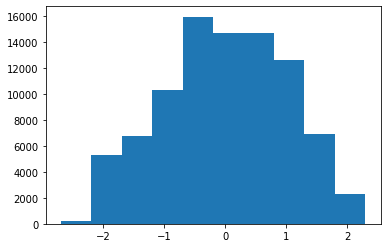

In [7]:
plt.hist(scaled.L);

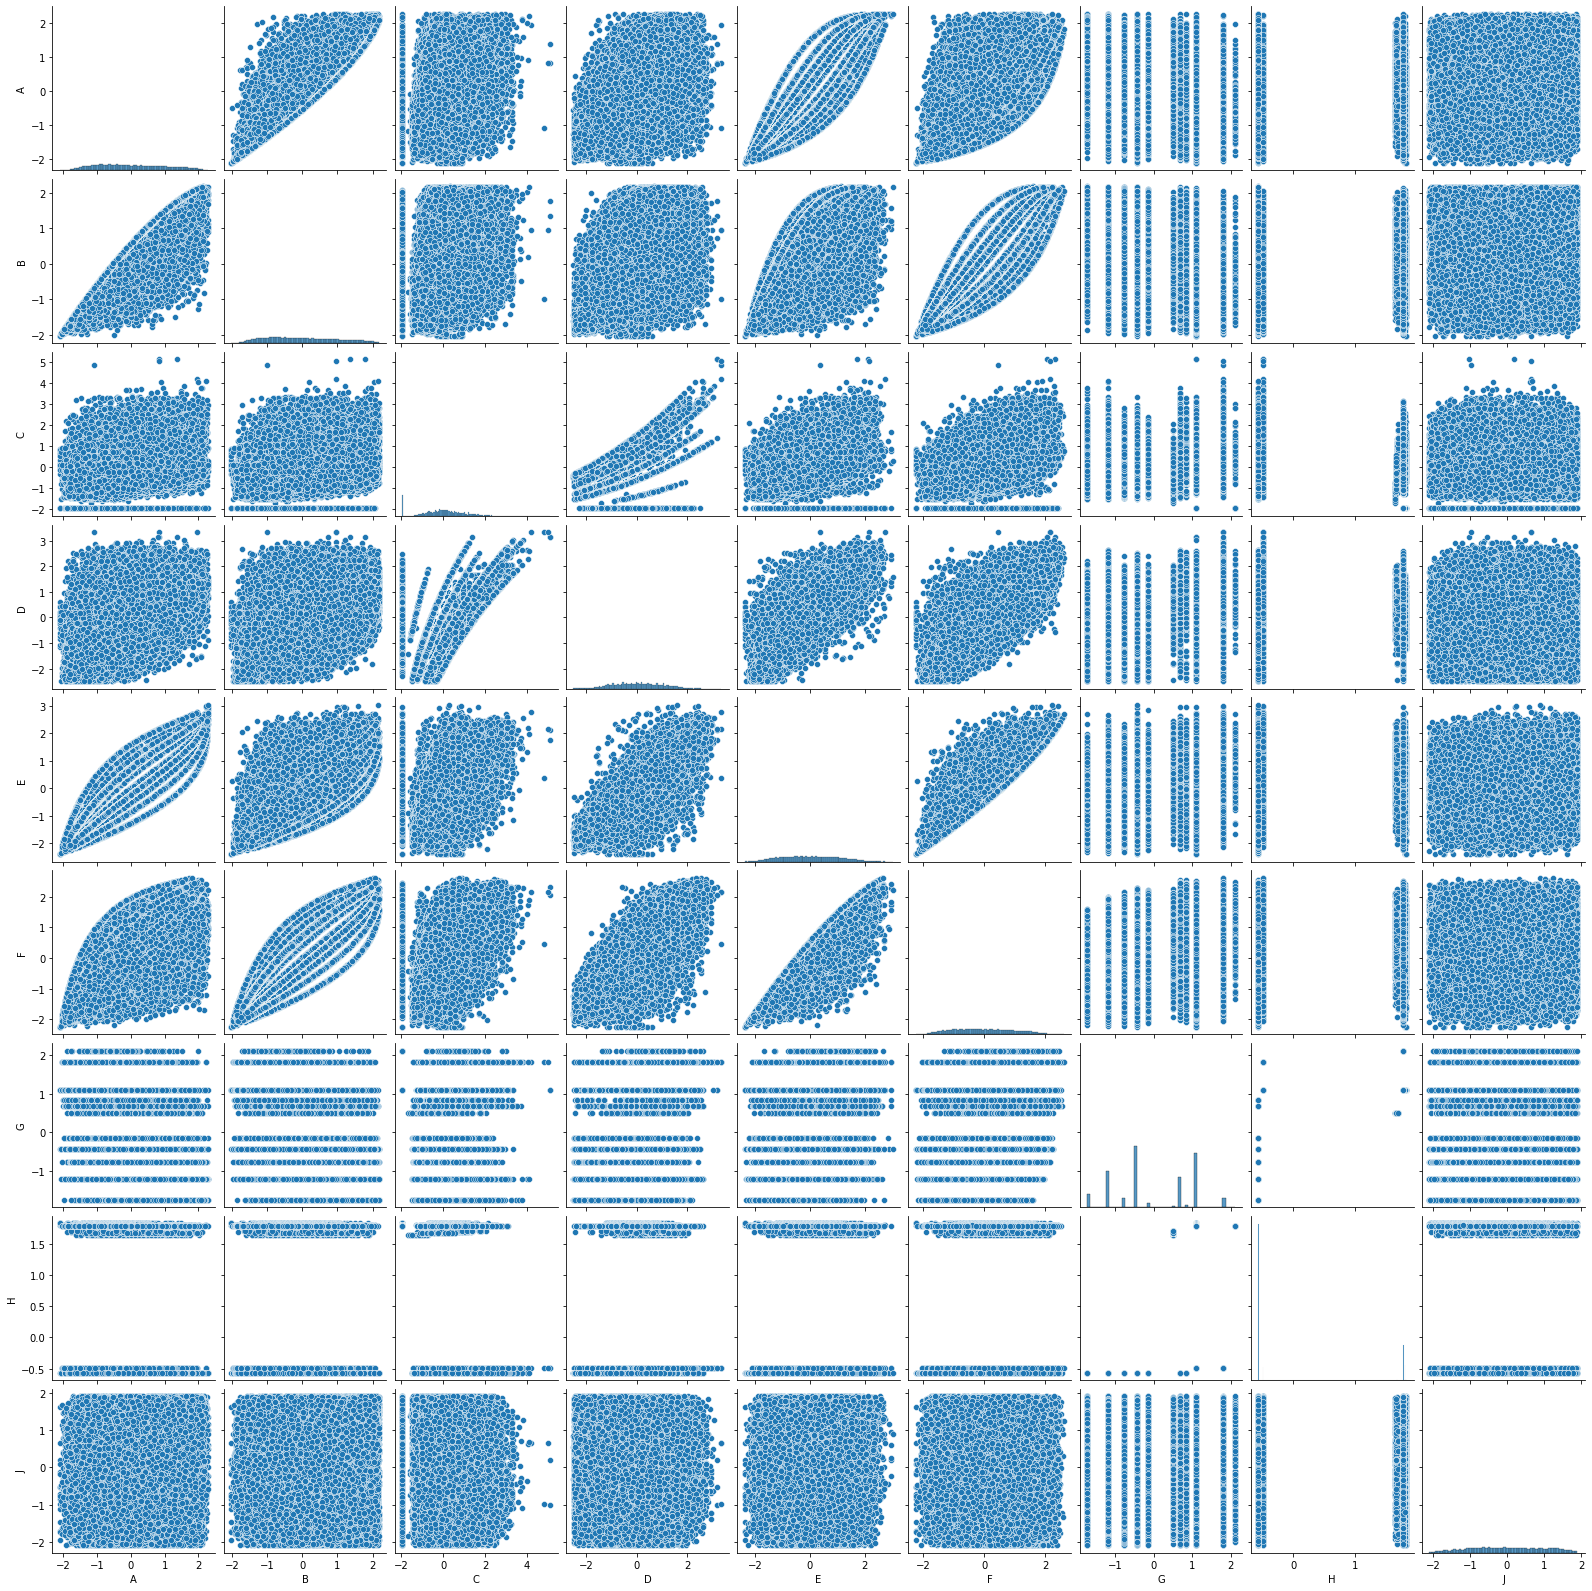

In [8]:
sns.pairplot(scaled[num_features[:-1]]);

Scatter plot below shows how imbalanced classes are

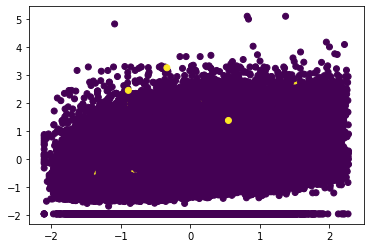

In [9]:
a = scaled.columns[0]
b = scaled.columns[2]
plt.scatter(scaled[a], scaled[b], c=df['MARKER']);

I found out that features below (`N`, `P`, `V`) are good to encode ordinary

In [10]:
cat_to_ord_encode = ['N', 'P', 'V']
for cat in cat_to_ord_encode:
    print(cat)
    print(df[cat].value_counts(), '\n')
    if cat in cat_features:
        cat_features.remove(cat)

N
Secondary education (plus special education)    58363
Higher education (one or more)                  30104
Incomplete higher education                       933
Primary or lower secondary education              334
Name: N, dtype: int64 

P
0 Zero         44229
1 One          25973
2 Two          16188
3 Three         2893
More than 3      451
Name: P, dtype: int64 

V
No     78462
Yes    10561
Few      711
Name: V, dtype: int64 



In [11]:
from sklearn.model_selection import train_test_split

X, y = df.drop('MARKER', axis=1), df['MARKER']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

## Logistic Regression

### Pipeline construction

Since classes are very imbalanced it's not representative to use accuracy for scoring. That's why we'll focus on sensitivity score and `classification_report`.

In [12]:
from imblearn.metrics import specificity_score
from imblearn.metrics import sensitivity_score
from imblearn.metrics import classification_report_imbalanced

def scoring(y_test, y_pred, display_report=False):
    """
    Function to display specificity and sensitivity scores. Also displays classification report
    ---
    params:
        y_test - iterable, one-dimensional array, actual values.
        y_pred - iterable, one-dimensional array, predicted values.
        display_report - wether dispaly or not classification report
    """
    print(f"Specificity: {specificity_score(y_test, y_pred)}")
    print(f"Sensitivity: {sensitivity_score(y_test, y_pred)}")
    if display_report:
        print(classification_report_imbalanced(y_test, y_pred))

To balance classes I will perform over-sampling using Adaptive Synthetic Sampling approach. I have chosen over-sampling but not under-sampling in order to save dependencies that might be useful for learning process.

In [13]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN


preprocessing = make_column_transformer(
    (OrdinalEncoder(), cat_to_ord_encode),
    (OneHotEncoder(), cat_features),
    (PowerTransformer(), num_features)
)

logreg_pip = make_pipeline(
    preprocessing,
    ADASYN(n_jobs=-1),
    LogisticRegression(n_jobs=-1, max_iter=5000)
)

In [14]:
logreg_pip.fit(X_train, y_train)
y_pred_logreg = logreg_pip.predict(X_test)

### Interpreting results

In [15]:
scoring(y_test, y_pred_logreg, display_report=True)

Specificity: 0.8224745762711865
Sensitivity: 0.7168141592920354
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.82      0.72      0.90      0.77      0.60     29500
          1       0.02      0.72      0.82      0.03      0.77      0.58       113

avg / total       0.99      0.82      0.72      0.90      0.77      0.60     29613



## Boosting algorithms

### Pipeline construction

In [21]:
from imblearn.ensemble import RUSBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBRFClassifier

rus_params = {
    'rusboostclassifier__n_estimators': [50, 100, 200],
    'rusboostclassifier__sampling_strategy': [0.1, 0.3, 0.5, 'auto'],
    'rusboostclassifier__learning_rate': [0.7, 1, 1.3]
}

xgb_params = {
    'xgbrfclassifier__n_estimators': [50, 100, 200],
    'xgbrfclassifier__learning_rate': [0.7, 1, 1.3],
    'xgbrfclassifier__reg_lambda': [1, 0.7, 0.5, 0.25, 0.1]
}

rus_pip = make_pipeline(
    preprocessing,
    ADASYN(n_jobs=-1),
    RUSBoostClassifier()
)

xgb_pip = make_pipeline(
    preprocessing,
    ADASYN(n_jobs=-1),
    XGBRFClassifier(
        n_jobs=-1, predictor='gpu_predictor',
        use_label_encoder=False, verbosity=1
    )
)

rus_grid = GridSearchCV(rus_pip, param_grid=rus_params, n_jobs=-1)
xgb_grid = GridSearchCV(xgb_pip, param_grid=xgb_params, n_jobs=-1)

In [17]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    rus_grid.fit(X_train, y_train);

### Results for RUSBoostClassifier

Since [RUSBoost uses under-sampling](https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.RUSBoostClassifier.html) to balance data, there is no point in over-sampling

In [18]:
y_pred_rus = rus_grid.predict(X_test)
scoring(y_test, y_pred_rus, display_report=True)
rus_grid.best_params_

Specificity: 0.9972542372881356
Sensitivity: 0.061946902654867256
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.06      1.00      0.25      0.07     29500
          1       0.08      0.06      1.00      0.07      0.25      0.06       113

avg / total       0.99      0.99      0.07      0.99      0.25      0.07     29613



{'rusboostclassifier__learning_rate': 1.3,
 'rusboostclassifier__n_estimators': 200,
 'rusboostclassifier__sampling_strategy': 'auto'}

### Results for XGBoostClassifier

For XGBoostClassifier I used same preprocessing pipeline as for Logistic Regression.

In [22]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    xgb_grid.fit(X_train, y_train)

[21:05:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:06:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:08:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:10:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [23]:
y_pred_xgb = xgb_grid.predict(X_test)
scoring(y_test, y_pred_xgb, display_report=True)
xgb_grid.best_params_

Specificity: 0.8701016949152542
Sensitivity: 0.5221238938053098
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.87      0.52      0.93      0.67      0.47     29500
          1       0.02      0.52      0.87      0.03      0.67      0.44       113

avg / total       0.99      0.87      0.52      0.93      0.67      0.47     29613



{'xgbrfclassifier__learning_rate': 1.3,
 'xgbrfclassifier__n_estimators': 50,
 'xgbrfclassifier__reg_lambda': 1}

## Comparing results

| Score | LogReg | RUSBoost | XGBoost |
|-------|--------|----------|---------|
| Sensitivity | 0.72 | 0.06 | 0.87 |
| Accuracy | 0.82 | 0.98 | 0.52 |

**Thank you for your time! I will apreciate seeing your feedback.**